In [1]:
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [2]:
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [1, 2, 3, 4, 5, 6]
PALETTE = ['#F08080', '#98FF00', '#228B22', '#FFC82D', '#A15622', '#000000']
SAMPLE_PATH = '../Conv1D_LULC_Classification/lc_gabung.csv'
IMAGE_PATH = '../Conv1D_LULC_Classification/Sentinel_Pidie_November_2024.tif'

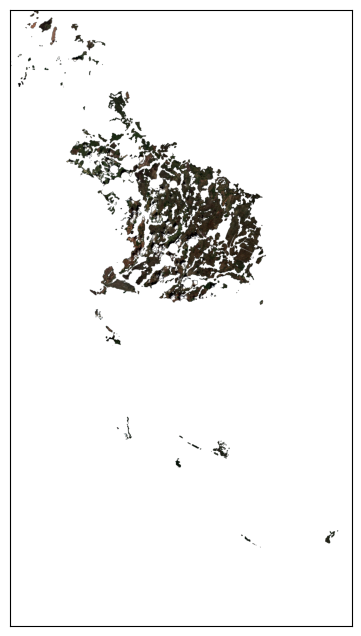

<Axes: >

In [3]:
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [1,2,3]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [4]:
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B8,B11,B12,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
290656,0.08490,0.08980,0.11275,0.11855,0.16045,0.07860,0.03930,0.087419,0.606508,0.342397,-0.174597,-0.342397,0.333333,12,1,train
274046,0.29520,0.27390,0.28320,0.26110,0.40480,0.30100,0.23220,0.391703,0.270958,0.147067,-0.176744,-0.147067,0.129032,7,1,train
12183,0.14745,0.15180,0.15285,0.14670,0.16045,0.12675,0.11445,0.038103,0.167334,0.117340,-0.024258,-0.117340,0.050995,7,1,train
367947,0.02450,0.03320,0.04890,0.02460,0.40980,0.17590,0.08330,0.736013,0.662138,0.399351,-0.786789,-0.399351,0.357253,70,3,train
336448,0.07825,0.07900,0.10175,0.08105,0.34560,0.19255,0.13645,0.533625,0.433876,0.284400,-0.545099,-0.284400,0.170517,15,5,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296338,0.03570,0.04550,0.06810,0.05020,0.25540,0.14970,0.07330,0.422101,0.554001,0.260923,-0.578980,-0.260923,0.342601,31,3,train
10094,0.05130,0.05320,0.06490,0.08030,0.14680,0.14930,0.08410,0.135207,0.271546,-0.008443,-0.386868,0.008443,0.279349,477,5,train
283435,0.28060,0.27000,0.28920,0.29790,0.41760,0.43450,0.32510,0.253602,0.124546,-0.019833,-0.181664,0.019833,0.144023,195,5,test
478,0.11115,0.08700,0.10555,0.10685,0.15255,0.09975,0.05905,0.100118,0.441871,0.209275,-0.182100,-0.209275,0.256297,4,1,train


In [5]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (344875, 14, 1)
Test features: (87794, 14, 1)
Train label: (344875, 7)
Test label: (87794, 7)


In [6]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.1
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel , activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool,pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool,pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 64)            192       
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            8256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 128)            16512     
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 128)            32896     
                                                        

In [7]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=10,
)

Epoch 1/10
337/337 [==============================] - 13s 36ms/step - loss: 1.2281 - accuracy: 0.5189 - val_loss: 1.0263 - val_accuracy: 0.5899
Epoch 2/10
337/337 [==============================] - 12s 36ms/step - loss: 1.0412 - accuracy: 0.5872 - val_loss: 0.9960 - val_accuracy: 0.6024
Epoch 3/10
337/337 [==============================] - 12s 36ms/step - loss: 1.0069 - accuracy: 0.6033 - val_loss: 0.9626 - val_accuracy: 0.6237
Epoch 4/10
337/337 [==============================] - 12s 36ms/step - loss: 0.9842 - accuracy: 0.6144 - val_loss: 0.9405 - val_accuracy: 0.6350
Epoch 5/10
337/337 [==============================] - 12s 37ms/step - loss: 0.9664 - accuracy: 0.6232 - val_loss: 0.9397 - val_accuracy: 0.6357
Epoch 6/10
337/337 [==============================] - 13s 37ms/step - loss: 0.9541 - accuracy: 0.6286 - val_loss: 0.9094 - val_accuracy: 0.6488
Epoch 7/10
337/337 [==============================] - 13s 37ms/step - loss: 0.9393 - accuracy: 0.6369 - val_loss: 0.9019 - val_accuracy:

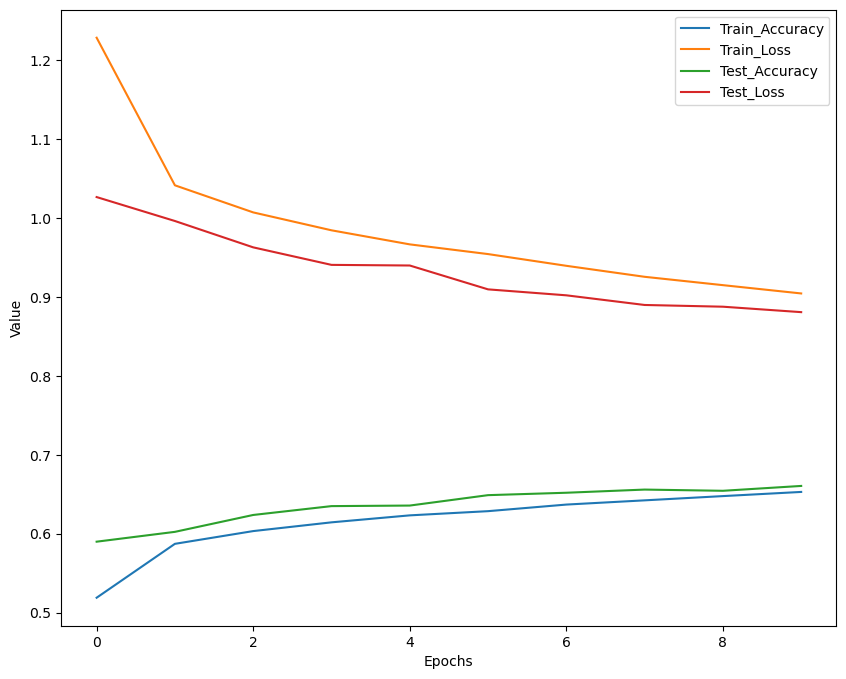

In [8]:
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

10778/10778 [==============================] - 9s 795us/step


c:\Users\jabir\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jabir\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.67      0.54      0.60     67274
           2       0.62      0.54      0.58     48963
           3       0.55      0.55      0.55     39252
           4       0.62      0.68      0.65     45311
           5       0.74      0.87      0.80    135487
           6       0.00      0.00      0.00      8588

    accuracy                           0.67    344875
   macro avg       0.53      0.53      0.53    344875
weighted avg       0.65      0.67      0.66    344875



c:\Users\jabir\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


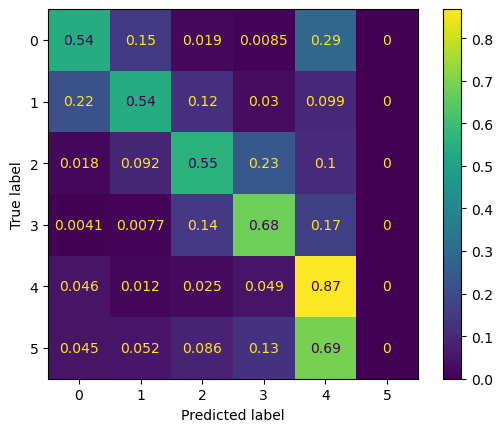

In [9]:
prediction = np.argmax(model.predict(train_input), 1).flatten()
label = np.argmax(train_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

2744/2744 [==============================] - 2s 898us/step
              precision    recall  f1-score   support

           1       0.66      0.55      0.60     17059
           2       0.62      0.50      0.56     13213
           3       0.51      0.53      0.52      9751
           4       0.56      0.68      0.61     10731
           5       0.74      0.85      0.79     34918
           6       0.00      0.00      0.00      2122

    accuracy                           0.66     87794
   macro avg       0.52      0.52      0.51     87794
weighted avg       0.64      0.66      0.65     87794



c:\Users\jabir\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jabir\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jabir\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


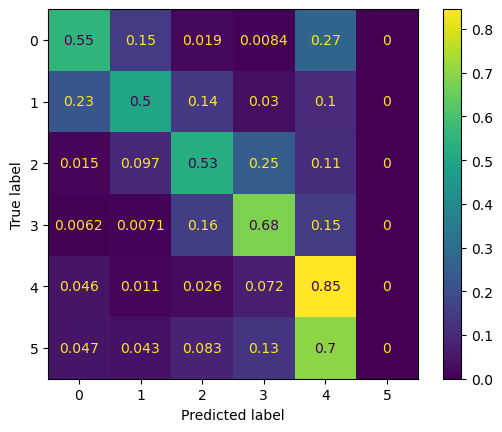

In [10]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

In [332]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
import numpy as np

In [333]:
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()
cm1 = confusion_matrix(label, prediction, normalize='true')
num_classes = 5
sensitivity = []
specificities = []

# Hitung sensitivitas untuk setiap kelas
for i in range(num_classes):
    TP = cm1[i, i]
    FN = np.sum(cm1[i, :]) - TP  # Jumlah semua FN untuk kelas i
    sensitivity_1 = TP / (TP + FN)
    sensitivity.append(sensitivity_1)

total = 0
for num in sensitivity:
    total += num

print("Sensitivity : ", total/6)

for i in range(num_classes):
    TN = np.sum(cm1) - np.sum(cm1[i, :]) - np.sum(cm1[:, i]) + cm1[i, i]
    FP = np.sum(cm1[:, i]) - cm1[i, i]
    specificity_1 = TN / (TN + FP)
    specificities.append(specificity_1)

total = 0
for num in specificities:
    total += num

print("Specificity : ", total/6)

mcc= matthews_corrcoef(label, prediction)
print('Matthews corrcoef : ',mcc)
KIA=cohen_kappa_score(label, prediction)
print('Cohen Kappa Index : ',KIA)

1779/1779 [==============================] - 2s 925us/step
Sensitivity :  0.6385529845406271
Specificity :  0.7648527006973764
Matthews corrcoef :  0.7077822068887777
Cohen Kappa Index :  0.7068319930063447


In [334]:
prediction = np.argmax(model.predict(train_input), 1).flatten()
label = np.argmax(train_output, 1).flatten()
cm1 = confusion_matrix(label, prediction, normalize='true')
num_classes = 6
sensitivity = []
specificities = []

# Hitung sensitivitas untuk setiap kelas
for i in range(num_classes):
    TP = cm1[i, i]
    FN = np.sum(cm1[i, :]) - TP  # Jumlah semua FN untuk kelas i
    sensitivity_1 = TP / (TP + FN)
    sensitivity.append(sensitivity_1)

total = 0
for num in sensitivity:
    total += num

print("Sensitivity : ", total/6)

for i in range(num_classes):
    TN = np.sum(cm1) - np.sum(cm1[i, :]) - np.sum(cm1[:, i]) + cm1[i, i]
    FP = np.sum(cm1[:, i]) - cm1[i, i]
    specificity_1 = TN / (TN + FP)
    specificities.append(specificity_1)

total = 0
for num in specificities:
    total += num

print("Specificity : ", total/6)

mcc= matthews_corrcoef(label, prediction)
print('Matthews corrcoef : ',mcc)
KIA=cohen_kappa_score(label, prediction)
print('Cohen Kappa Index : ',KIA)

7160/7160 [==============================] - 7s 916us/step
Sensitivity :  0.7150520438789817
Specificity :  0.9430104087757963
Matthews corrcoef :  0.7694212700557551
Cohen Kappa Index :  0.7685090421883878


1779/1779 [==============================] - 2s 913us/step


c:\Users\jabir\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\jabir\AppData\Local\Temp\ipykernel_36572\35139391.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 8)


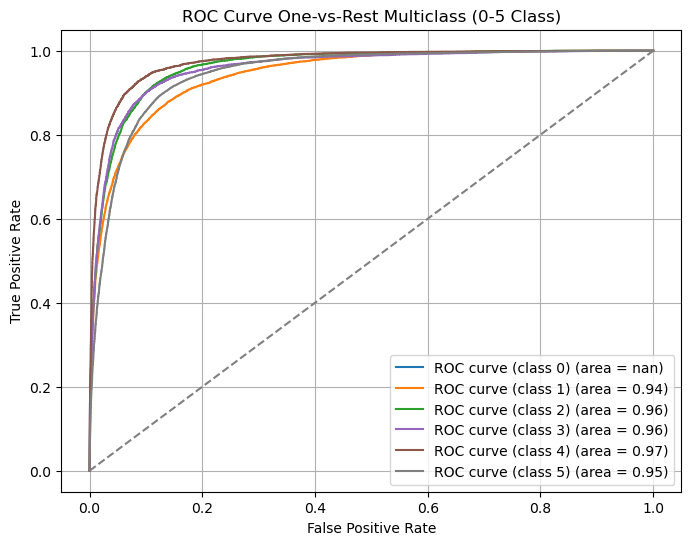

In [335]:
y_prob = model.predict(test_input)

# Hitung ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(test_output[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve untuk setiap kelas
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', 8)

for i in range(6):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

# Plot garis diagonal untuk referensi
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Tambahkan label dan judul pada plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve One-vs-Rest Multiclass (0-5 Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

7160/7160 [==============================] - 7s 910us/step


c:\Users\jabir\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\jabir\AppData\Local\Temp\ipykernel_36572\1659345763.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 6)


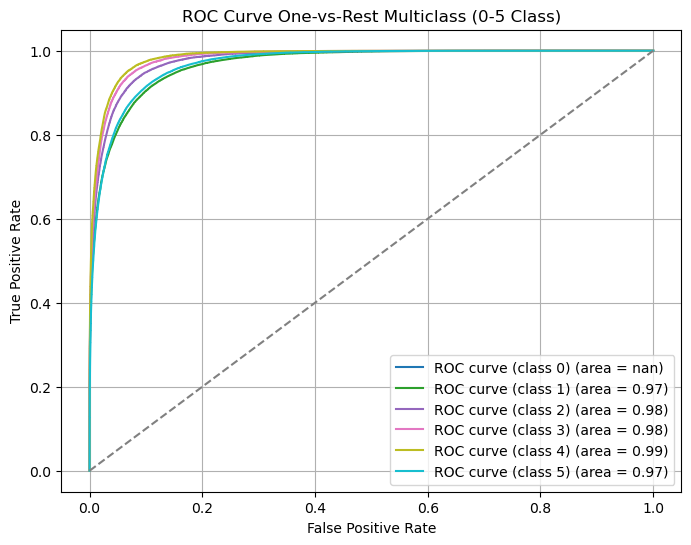

In [336]:
y_prob = model.predict(train_input)

# Hitung ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(train_output[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve untuk setiap kelas
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', 6)

for i in range(6):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

# Plot garis diagonal untuk referensi
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Tambahkan label dan judul pada plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve One-vs-Rest Multiclass (0-5 Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()